In [36]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
os.listdir("results")

['results']

### Data structure
- iteration
    - noise level
        - inlier level
            - [num_of_inliers, num_of_iters, cost, time]
            
what can be interesting for us ? 
 - ratio x noise x mean number of inliers
 - ratio x noise x mean cost
 - ratio x noise x mean time
 - ratio x noise x mean number of iterations

 - for inlier ratio = x, plot quantiles of some statistics over noise levels
 - for noise level = x, plot quantiles of some statistics over inlier ratio

In [48]:
from collections import defaultdict

In [49]:
AggrDict = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(
            lambda: defaultdict(
                lambda: [])
        )
    )
)

RansacStatsDict = lambda: defaultdict(
        lambda: defaultdict(
            lambda: defaultdict(
                lambda: [])
        )
    )

In [50]:
RESULTS_DIR = "results/results"
NUMBER_OF_SOLVERS = 3
RATIOS = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95]
DEVS=[0, 2, 5, 10, 15, 25, 45]

In [51]:
def aggregate_data(dirpath: str, num_of_solvers: int, ratios: list[float]) -> AggrDict:
    res = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(
            lambda: defaultdict(
                lambda: [])
            )
        )
    )
    
    for file in os.listdir(dirpath):
        with open(os.path.join(dirpath, file)) as f:
            data = f.readlines()

        file = file.split(".")[0]
        iteration, noise = map(int, file.split("_")[1:])

        data = [[float(elm) for elm in entry.strip("\n").split(",")] for entry in data]
        data = [[elm if idx == 4 or idx == 2 else int(elm) for idx, elm in enumerate(entry)]\
                for entry in data]

        ratio = 0
        for idx, elm in enumerate(data):
            if idx % num_of_solvers == 0 and idx != 0:
                ratio += 1
            elm.pop(2)
            res[idx % num_of_solvers][iteration][noise][ratios[ratio % len(ratios)]].append(elm)
            
    return res

In [52]:
data = aggregate_data(RESULTS_DIR, NUMBER_OF_SOLVERS, RATIOS)


In [53]:
data

defaultdict(<function __main__.aggregate_data.<locals>.<lambda>()>,
            {0: defaultdict(<function __main__.aggregate_data.<locals>.<lambda>.<locals>.<lambda>()>,
                         {4: defaultdict(<function __main__.aggregate_data.<locals>.<lambda>.<locals>.<lambda>.<locals>.<lambda>()>,
                                      {15: defaultdict(<function __main__.aggregate_data.<locals>.<lambda>.<locals>.<lambda>.<locals>.<lambda>.<locals>.<lambda>()>,
                                                   {0.0: [[2000,
                                                      100,
                                                      5191,
                                                      1.01356,
                                                      1]],
                                                    0.1: [[1800,
                                                      100,
                                                      33625,
                                         

In [54]:
# ratio x noise x mean time 
def get_table(data: AggrDict, ratios: list[float], devs: list[float], metric: int):
    
    dev_map = {dev: i for i, dev in enumerate(devs)}
    ratio_map = {ratio: i for i, ratio in enumerate(ratios)}
    
    def extract_info(r: AggrDict):
        resulting = [[0 for _ in range(len(ratios))] for _ in range(len(devs))]
        
        iters = len(r)
        
        for i in range(iters):
            for dev in r[i]:
                for ratio in r[i][dev]:
                    # print(resulting[dev_map[dev]][ratio_map[ratio]], r[i][dev][ratio][0][metric])
                    resulting[dev_map[dev]][ratio_map[ratio]] += \
                            r[i][dev][ratio][0][metric]
                    
        for i in range(len(ratios)):
            for j in range(len(devs)):
                resulting[j][i] /= iters
                    
        return resulting
    
    return [extract_info(data[r]) for r in data]

In [55]:
def plot_table(r: RansacStatsDict, title: str):
    plt.figure(figsize=(12,12))
    s = sns.heatmap(r, annot=True, fmt=".2f", linewidths=.5, cmap="YlGnBu",
               xticklabels=RATIOS, yticklabels=DEVS, label="h")
    s.set(xlabel='Ratio of inliers', ylabel='Vertical direction deviation')
    s.set_title(title)
    plt.show()

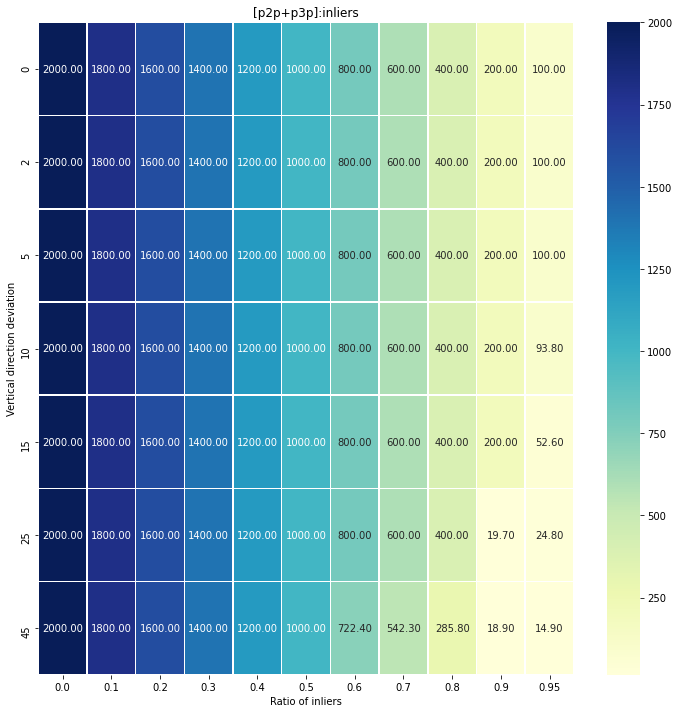

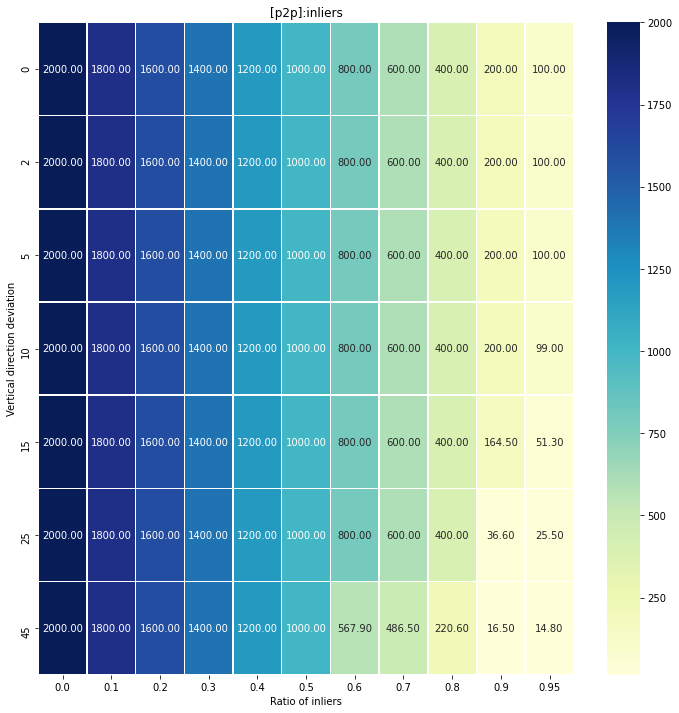

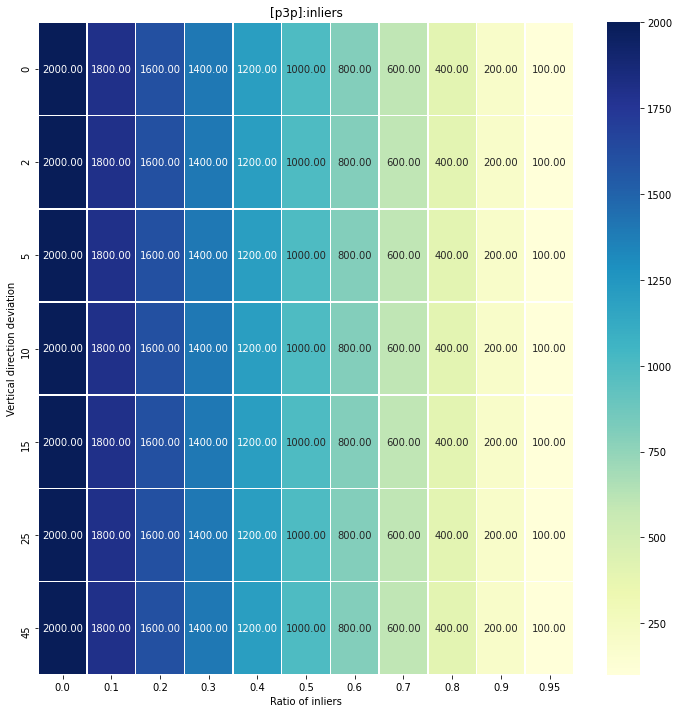

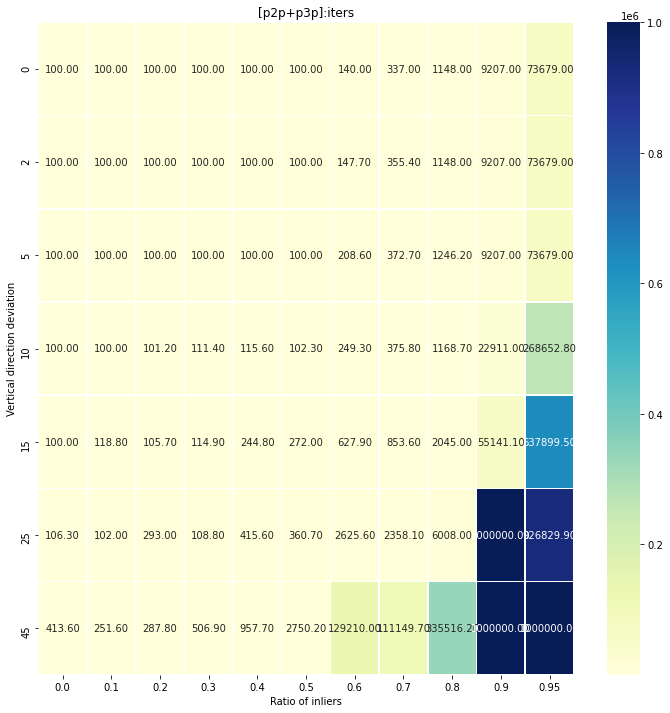

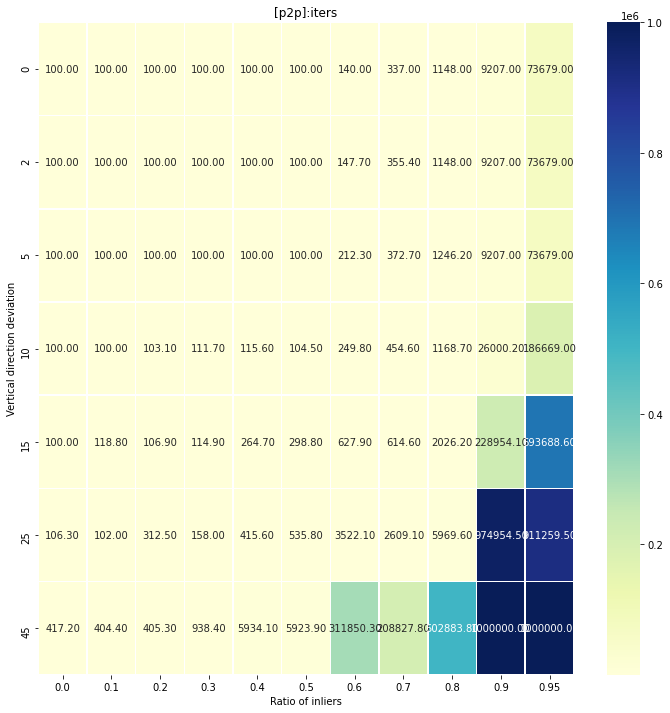

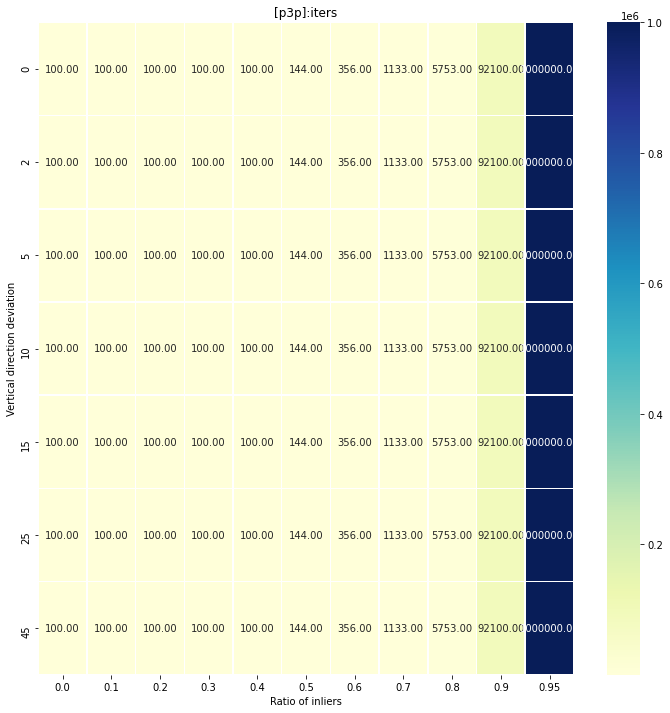

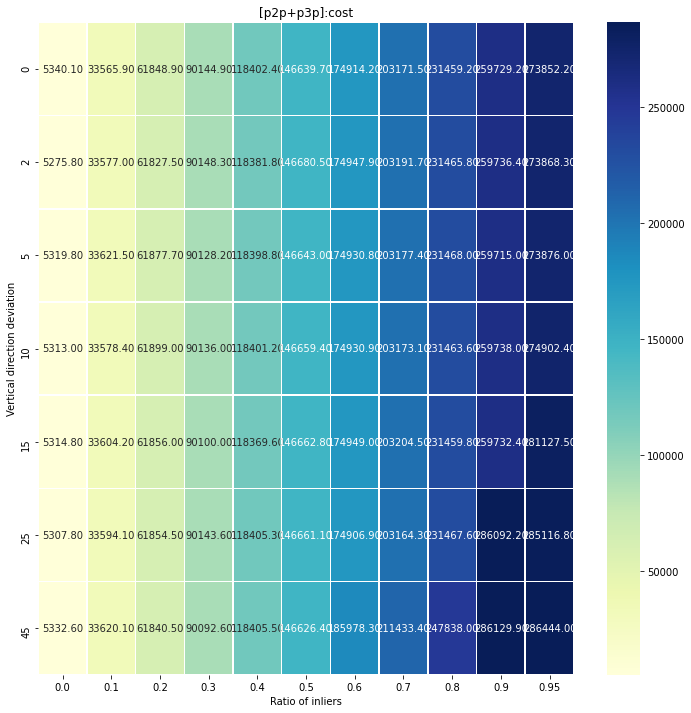

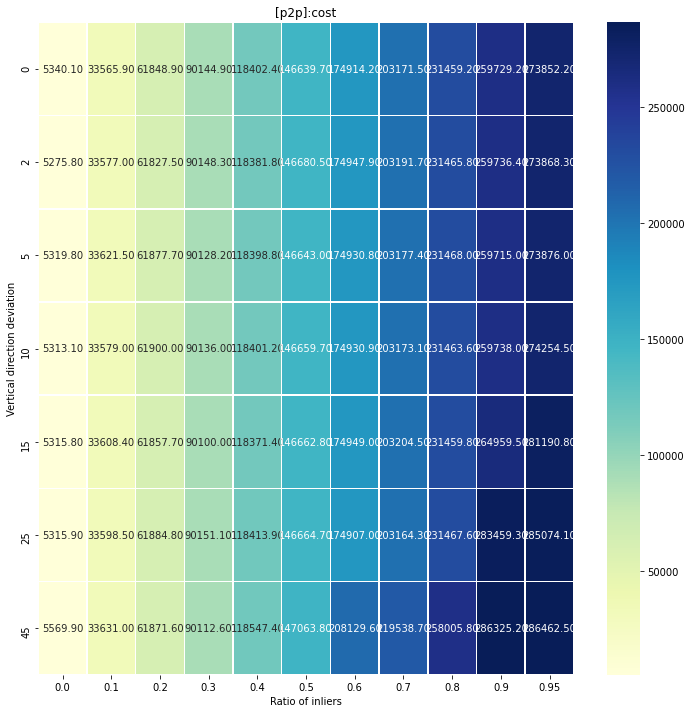

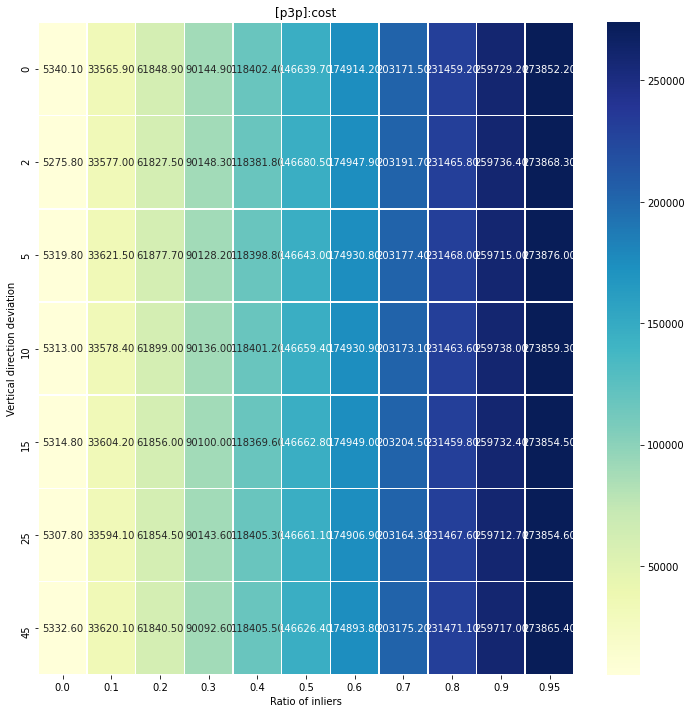

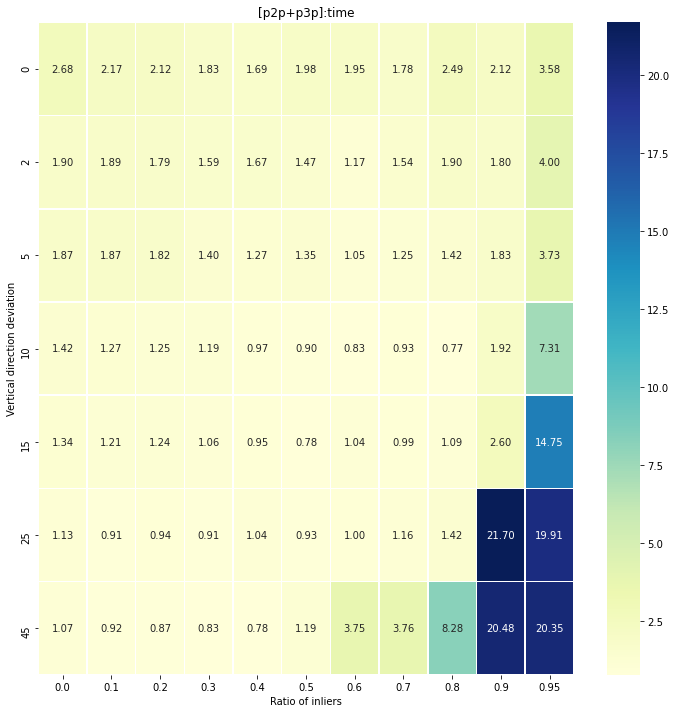

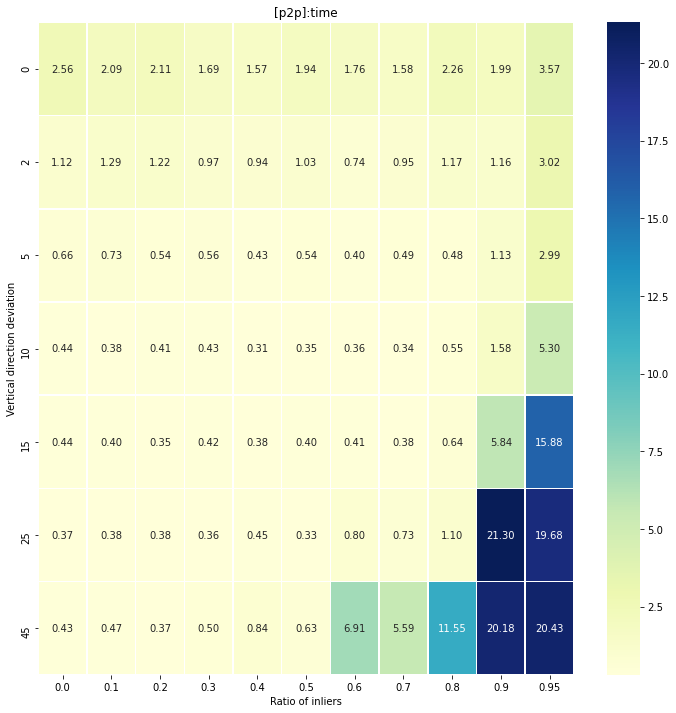

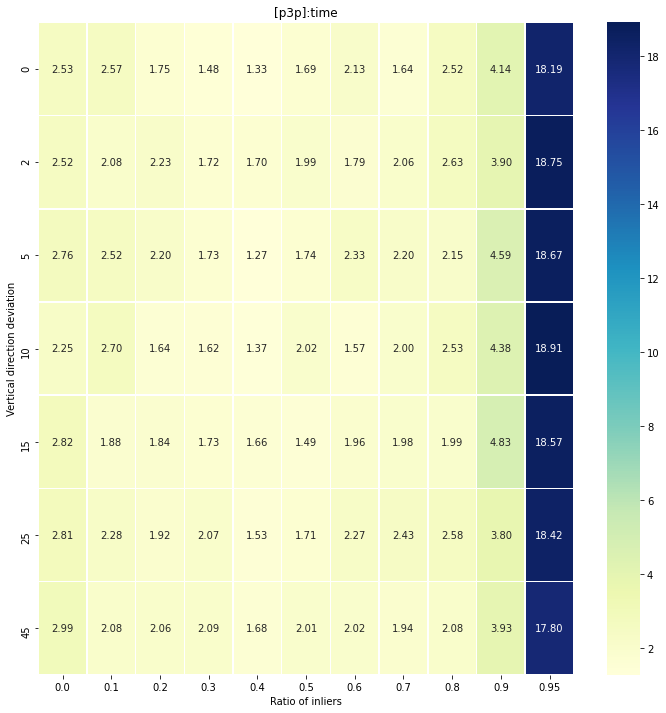

In [56]:
solv = {
    0: "p2p+p3p",
    1: "p2p",
    2: "p3p",
}

task = {
    0: "inliers",
    1: "iters",
    2: "cost",
    3: "time"
}

for i in range(4):
    d = get_table(data, RATIOS, DEVS, i)
    for j, sub in enumerate(d):
        plot_table(sub, f"[{solv[j]}]:{task[i]}")

In [17]:
# for inlier ratio = x, plot quantiles of some statistics over noise levels
def get_quantiles(data: AggrDict, inlier_ratio: float, metric: int):
    noise_levels = defaultdict(lambda: [])
    
    for i in range(len(data)):
        for noise_level in data[i]:
            
            e = data[i][noise_level][inlier_ratio]
            noise_levels[noise_level].append(e[0][metric])
            
    return noise_levels        

In [18]:
d = get_quantiles(data[0], 0.6, 0)

In [19]:
def plot_quantiles(data: defaultdict, metric: str):
    
    d = data.items()
    d = sorted(d, key=lambda x: x[0])
    
    devs = [elm[0] for elm in d]
    vals = [elm[1] for elm in d]
    
    fig1, ax1 = plt.subplots(figsize=(12, 12))
#     ax1.set_title('')
    ax1.boxplot(vals, labels=devs)
    plt.show()

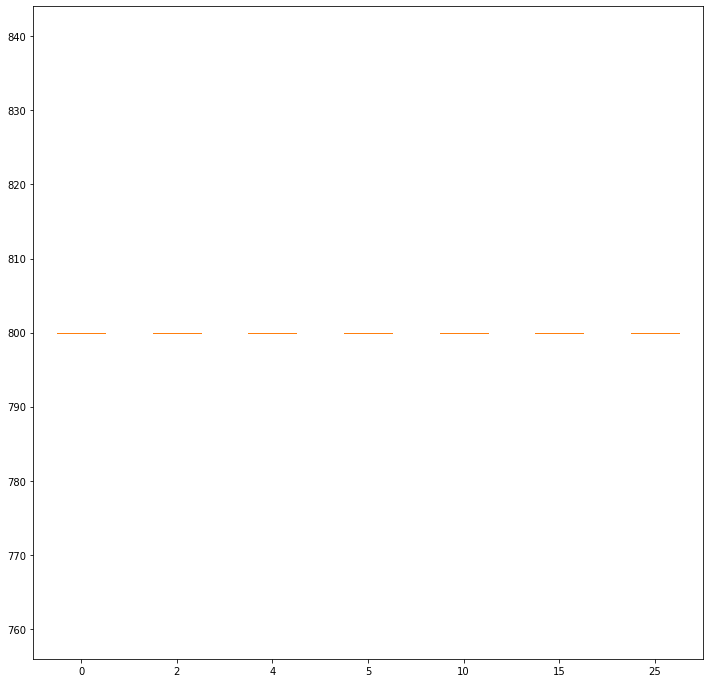

In [20]:
plot_quantiles(d, "Number of inliers")